# Classification of Events in High Energy Physics: Signal or Background?

Event classification plays a crucial role in High Energy Physics (HEP). When analyzing experimental data, physicists often search for rare events hidden within a vast background of unwanted interactions. These backgrounds can arise for various reasons: the event of interest might be intrinsically rare, or the experimental setup itself may produce a high rate of background events.

Traditionally, physicists have tackled this problem by applying selection criteria to specific event features, such as kinematic variables. By identifying patterns in these variables, one can enhance the signal-to-background ratio, increasing the likelihood of detecting meaningful events. However, as experiments become more complex and datasets grow larger, machine learning (ML) methods offer a more powerful and automated approach to classification.

In this tutorial, we will introduce a simple ML-based approach to event classification. We will start from the basics, using a straightforward dataset and applying a classification model to separate signal from background. By the end, you will understand how ML can be used to optimize event selection in HEP, and how it compares to traditional methods.

## Implementation of an event classifier

### 1) Import and prepare datasets

In [1]:
import uproot
import numpy as np
import pandas as pd
from sklearn.utils import shuffle
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

In [2]:
signal_root_file = uproot.open("./new_denseNtuple_ZpToVisible_5000_MeV.root")
background_root_file = uproot.open("./new_Zp_MuMuMuMu_4C_9.root")

In [3]:
signal_tree = signal_root_file["zp"]
background_tree = background_root_file["zp"]

In [4]:
raw_variables = ['Zp_cm_p_beforeFit', 'P_beforeFit', 'Zp_tau0_CMS_p_beforeFit', 'Zp_tau1_CMS_p_beforeFit', 
                 'fake_tau0_CMS_p_beforeFit', 'fake_tau1_CMS_p_beforeFit', 'fake_tau0_CMS_pt_beforeFit', 
                 'fake_tau1_CMS_pt_beforeFit', 'fake_PtTheta_beforeFit', 'fake_PtRho_beforeFit', 
                 'IntSymmZp_Pt_beforeFit', 'DistZp_Pt_beforeFit', 'Zp_PtTheta_sign_beforeFit', 
                 'Zp_PtRho_sign_beforeFit', 'Zp_ptPtMin_Theta_beforeFit', 'Zp_ptPtMin_Rho_beforeFit']
mcTruth_variables = ['Zp_tau_0_dau_genMotherPDG', 'Zp_tau_1_dau_genMotherPDG']
mass_variables = ['M_beforeFit', 'Zp_M_beforeFit', 'genMass', 'baseline']

In [5]:
branches = raw_variables+mcTruth_variables+mass_variables

In [6]:
print(branches)

['Zp_cm_p_beforeFit', 'P_beforeFit', 'Zp_tau0_CMS_p_beforeFit', 'Zp_tau1_CMS_p_beforeFit', 'fake_tau0_CMS_p_beforeFit', 'fake_tau1_CMS_p_beforeFit', 'fake_tau0_CMS_pt_beforeFit', 'fake_tau1_CMS_pt_beforeFit', 'fake_PtTheta_beforeFit', 'fake_PtRho_beforeFit', 'IntSymmZp_Pt_beforeFit', 'DistZp_Pt_beforeFit', 'Zp_PtTheta_sign_beforeFit', 'Zp_PtRho_sign_beforeFit', 'Zp_ptPtMin_Theta_beforeFit', 'Zp_ptPtMin_Rho_beforeFit', 'Zp_tau_0_dau_genMotherPDG', 'Zp_tau_1_dau_genMotherPDG', 'M_beforeFit', 'Zp_M_beforeFit', 'genMass', 'baseline']


In [7]:
background_data = background_tree.arrays(branches, library="pd")
signal_data = signal_tree.arrays(branches, library="pd")

In [8]:
background_data = background_data[(background_data['Zp_M_beforeFit'] > 4.5) & (background_data['Zp_M_beforeFit'] < 5.5)]                                 
signal_data = signal_data[(signal_data['Zp_tau_0_dau_genMotherPDG'] == 26) & (signal_data['Zp_tau_1_dau_genMotherPDG'] == 26)]

#### Look at distributions to check what is our dataset like

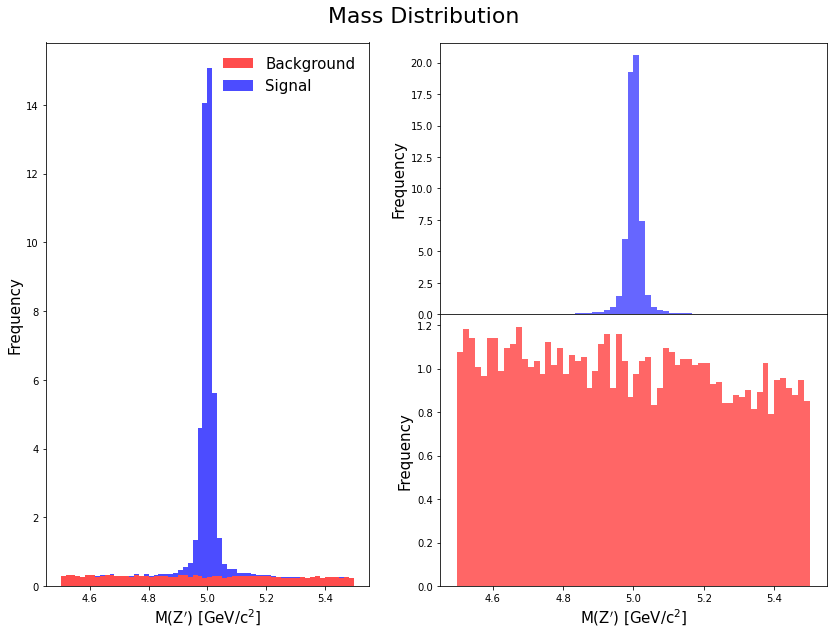

In [9]:
fig = plt.figure(figsize=(14, 10))
fig.suptitle('Mass Distribution', fontsize=22, y = 0.93)
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1.2], wspace=0.2)
ax1 = fig.add_subplot(gs[0])
ax1.hist([background_data['Zp_M_beforeFit'], signal_data['Zp_M_beforeFit']], range = (4.5, 5.5), bins=60, 
         color=['red', 'blue'], alpha=0.7, label=['Background', 'Signal'], edgecolor='none', density = True, 
         stacked=True)
ax1.set_xlabel('M(Z$^{\prime}$) [GeV/c$^{2}$]', fontsize = 15)
ax1.set_ylabel('Frequency', fontsize = 15)
ax1.legend(frameon = False, fontsize = 15)

gs_right = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=gs[1], hspace=0)
ax2 = fig.add_subplot(gs_right[0])
ax2.hist(signal_data['Zp_M_beforeFit'], range = (4.5, 5.5), bins=60, color='blue', alpha=0.6, edgecolor='none', 
         density = True)
ax2.set_xlabel('M(Z$^{\prime}$) [GeV/c$^{2}$]', fontsize = 15)
ax2.set_ylabel('Frequency', fontsize = 15)

ax3 = fig.add_subplot(gs_right[1])
ax3.hist(background_data['Zp_M_beforeFit'], range = (4.5, 5.5), bins=60, color='red', alpha=0.6, edgecolor='none', 
         density = True)
ax3.set_xlabel('M(Z$^{\prime}$) [GeV/c$^{2}$]', fontsize = 15)
ax3.set_ylabel('Frequency', fontsize = 15)

plt.show()

### 2) Select features

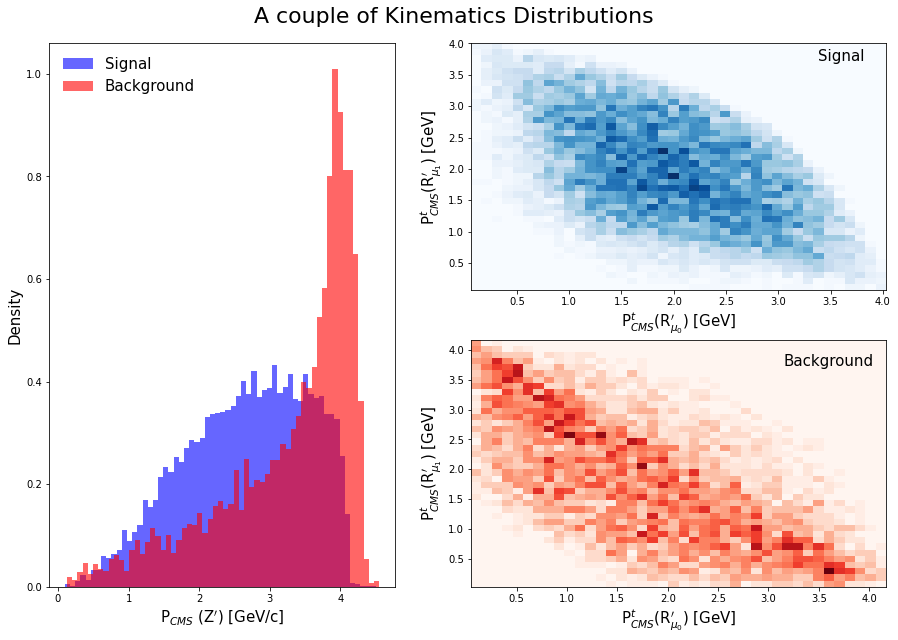

In [10]:
fig = plt.figure(figsize=(15, 10))
fig.suptitle('A couple of Kinematics Distributions', fontsize=22, y = 0.93)
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1.2], wspace=0.2)
ax1 = fig.add_subplot(gs[0])
ax1.hist(signal_data['Zp_cm_p_beforeFit'], bins=60, color='blue', alpha=0.6, label='Signal', 
           edgecolor='none', density = True)
ax1.hist(background_data['Zp_cm_p_beforeFit'], bins=60, color='red', alpha=0.6, label='Background', 
           edgecolor='none', density = True)
ax1.set_xlabel('P$_{CMS}$ (Z$^{\prime}$) [GeV/c]', fontsize=15)
ax1.set_ylabel('Density', fontsize=15)
ax1.legend(frameon = False, fontsize=15)

gs_right = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=gs[1], hspace=0.2)
ax2 = fig.add_subplot(gs_right[0])
ax2.hist2d(signal_data['fake_tau0_CMS_pt_beforeFit'], signal_data['fake_tau1_CMS_pt_beforeFit'], 
             bins=(40, 40), cmap='Blues', density=True)
ax2.set_xlabel('P$^{t}_{CMS}$(R$^{\prime}_{\mu_{0}}$) [GeV]', fontsize=15)
ax2.set_ylabel('P$^{t}_{CMS}$(R$^{\prime}_{\mu_{1}}$) [GeV]', fontsize=15)
ax2.text(3.6, 3.8, "Signal", fontsize=15, color="black", ha="center", va="center")

ax3 = fig.add_subplot(gs_right[1])
ax3.hist2d(background_data['fake_tau0_CMS_pt_beforeFit'], background_data['fake_tau1_CMS_pt_beforeFit'], 
             bins=(40, 40), cmap='Reds', density=True)
ax3.set_xlabel('P$^{t}_{CMS}$(R$^{\prime}_{\mu_{0}}$) [GeV]', fontsize=15)
ax3.set_ylabel('P$^{t}_{CMS}$(R$^{\prime}_{\mu_{1}}$) [GeV]', fontsize=15)
ax3.text(3.6, 3.8, "Background", fontsize=15, color="black", ha="center", va="center")

plt.show()

In [11]:
selected = ['Zp_cm_p_beforeFit', 'P_beforeFit', 'Zp_tau0_CMS_p_beforeFit', 'Zp_tau1_CMS_p_beforeFit', 
            'fake_tau0_CMS_p_beforeFit', 'fake_tau1_CMS_p_beforeFit', 'fake_tau0_CMS_pt_beforeFit', 
            'fake_tau1_CMS_pt_beforeFit', 'fake_PtTheta_beforeFit', 'fake_PtRho_beforeFit', 
            'IntSymmZp_Pt_beforeFit', 'DistZp_Pt_beforeFit', 'Zp_PtTheta_sign_beforeFit', 
            'Zp_PtRho_sign_beforeFit', 'Zp_ptPtMin_Theta_beforeFit', 'Zp_ptPtMin_Rho_beforeFit']

#### prepare dataset for the training

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [13]:
X_signal = signal_data[selected].values
X_background = background_data[selected].values

In [14]:
y_signal = np.ones(len(signal_data)) 
y_background = np.zeros(len(background_data)) 

In [15]:
X = np.vstack((X_signal, X_background))  
y = np.hstack((y_signal, y_background))  

In [16]:
X, y = shuffle(X, y, random_state=42)

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [18]:
import joblib
joblib.dump(scaler, "scaler.pkl")

['scaler.pkl']

#### check features correlation

In [19]:
train_df = pd.DataFrame(X_train, columns=selected)

In [20]:
corr_matrix = train_df.corr()

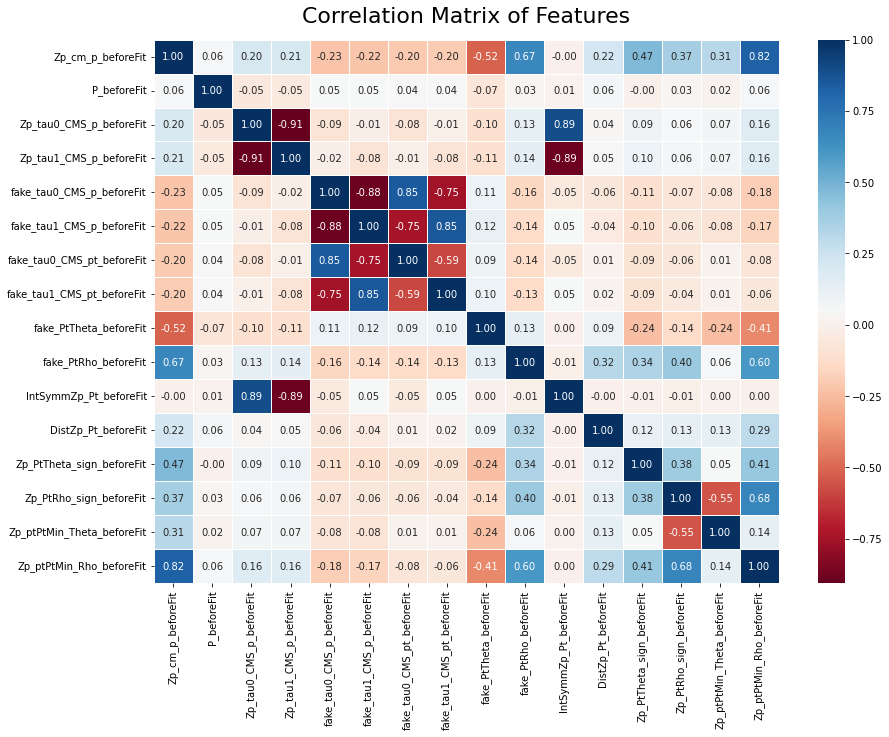

In [21]:
plt.figure(figsize=(14, 10))
sns.heatmap(corr_matrix, annot=True, cmap='RdBu', fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix of Features", fontsize=22, y=1.02)
plt.show()

###  3) Choose a Classifier

#### import classifiers and load them in a dictionary

In [22]:
from sklearn.metrics import roc_curve, auc
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier

In [23]:
classifiers = {
    'Logistic Regression': LogisticRegression(max_iter=500),
    'Random Forest': RandomForestClassifier(n_estimators=50, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=50, random_state=42),
    'SVM': SVC(probability=True, random_state=42),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Naive Bayes': GaussianNB(),
    'MLP Neural Network': MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=500, random_state=42)
}

#### train your models

In [24]:
for name, model in classifiers.items():
    model.fit(X_train, y_train)

#### compute ROC curves and AUC scores for all classifiers

In [25]:
roc_auc_scores = []

for name, model in classifiers.items():

    y_pred_prob = model.predict_proba(X_test)[:, 1]
    
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    roc_auc = auc(fpr, tpr)
    
    roc_auc_scores.append((name, fpr, tpr, roc_auc))

In [26]:
roc_auc_scores.sort(key=lambda x: x[3], reverse=True)

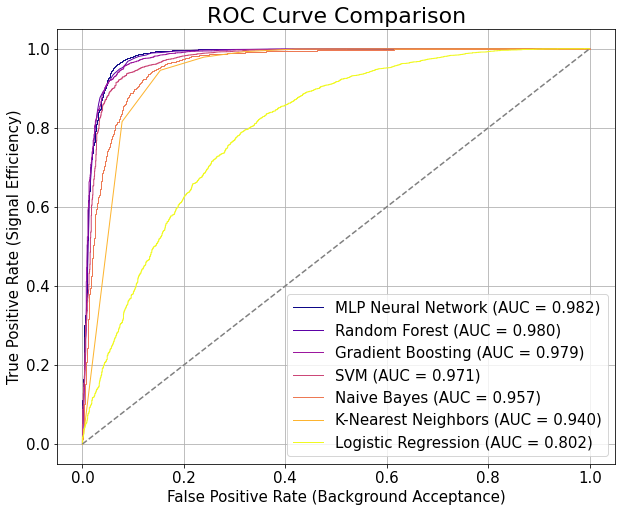

In [27]:
plt.figure(figsize=(10, 8))
colors = plt.cm.plasma(np.linspace(0, 1, len(classifiers)))

for (name, fpr, tpr, roc_auc), color in zip(roc_auc_scores, colors):
    plt.plot(fpr, tpr, color=color, lw=1, label=f"{name} (AUC = {roc_auc:.3f})")

plt.plot([0, 1], [0, 1], linestyle="--", color="gray")

plt.xlabel("False Positive Rate (Background Acceptance)", fontsize=15)
plt.ylabel("True Positive Rate (Signal Efficiency)", fontsize=15)
plt.title("ROC Curve Comparison", fontsize=22)
plt.legend(fontsize=15)
plt.grid()
plt.tick_params(axis="both", labelsize=15)
plt.show()

### 4) Tune the model showing the highest AUC score

In [28]:
import ipywidgets as widgets

In [29]:
# Function to update and plot ROC curve
def plot_roc(hidden_layer_1, hidden_layer_2, activation, solver, alpha, learning_rate, max_iter):
    hidden_layers = (hidden_layer_1, hidden_layer_2)
    
    model = MLPClassifier(
        hidden_layer_sizes=hidden_layers,
        activation=activation,
        solver=solver,
        alpha=alpha,
        learning_rate=learning_rate,
        max_iter=max_iter,
        random_state=42
    )
    
    model.fit(X_train, y_train)
    y_pred_prob = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(10, 8))
    plt.plot(fpr, tpr, color='navy', label=f'MLPClassifier (AUC = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel("False Positive Rate", fontsize=15)
    plt.ylabel("True Positive Rate", fontsize=15)
    plt.title("ROC Curve - MLP Classifier", fontsize=22)
    plt.legend(loc="lower right", fontsize=15)
    plt.grid()
    plt.tick_params(axis="both", labelsize=15)
    plt.show()

In [30]:
hidden_layer_1_widget = widgets.IntSlider(value=64, min=16, max=80, step=2, description='Layer 1 Neurons:')
hidden_layer_2_widget = widgets.IntSlider(value=32, min=16, max=80, step=2, description='Layer 2 Neurons:')
activation_widget = widgets.Dropdown(options=['identity', 'logistic', 'tanh', 'relu'], value='relu', description='Activation:')
solver_widget = widgets.Dropdown(options=['lbfgs', 'sgd', 'adam'], value='adam', description='Solver:')
alpha_widget = widgets.FloatLogSlider(value=0.0001, min=-5, max=0, step=0.1, base=10, description='Alpha:')
learning_rate_widget = widgets.Dropdown(options=['constant', 'invscaling', 'adaptive'], value='constant', description='Learning Rate:')
max_iter_widget = widgets.IntSlider(value=500, min=100, max=2000, step=100, description='Max Iterations:')

In [31]:
display(widgets.interactive(plot_roc, 
                            hidden_layer_1=hidden_layer_1_widget,
                            hidden_layer_2=hidden_layer_2_widget,
                            activation=activation_widget,
                            solver=solver_widget,
                            alpha=alpha_widget,
                            learning_rate=learning_rate_widget,
                            max_iter=max_iter_widget))

interactive(children=(IntSlider(value=64, description='Layer 1 Neurons:', max=80, min=16, step=2), IntSlider(v…

#### train your model using the tuned parameters and save the model for later applications

In [32]:
mlp = MLPClassifier(hidden_layer_sizes=(64, 32), activation='relu', solver='adam', max_iter=500, random_state=42)
mlp.fit(X_train, y_train)

MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=500, random_state=42)

In [33]:
import joblib
joblib.dump(mlp, "mlp_model.pkl")

['mlp_model.pkl']

### 4) Evaluate your Model

#### Confusion Matrix

In [34]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [35]:
y_pred = mlp.predict(X_test)

In [36]:
cm = confusion_matrix(y_test, y_pred)

Text(0.5, 1.0, 'Confusion Matrix')

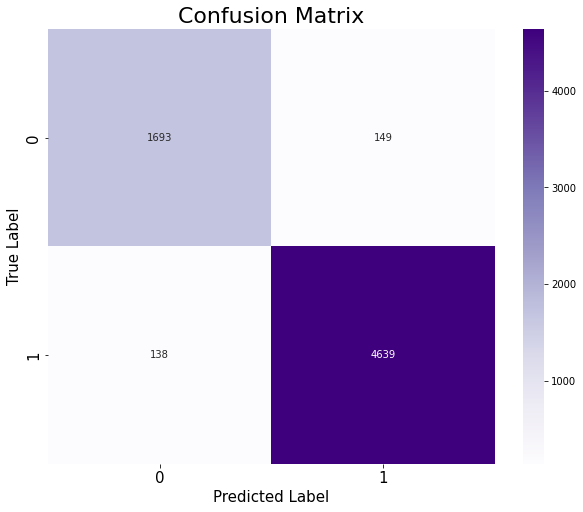

In [37]:
plt.figure(figsize=(10, 8))
ax = sns.heatmap(cm, annot=True, fmt='d', cmap="Purples", linewidths=0.0, linecolor='black')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel("Predicted Label", fontsize=15)
plt.ylabel("True Label", fontsize=15)
plt.title("Confusion Matrix", fontsize=22)

#### ROC curve 

In [38]:
y_prob = mlp.predict_proba(X_test)[:, 1]  
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

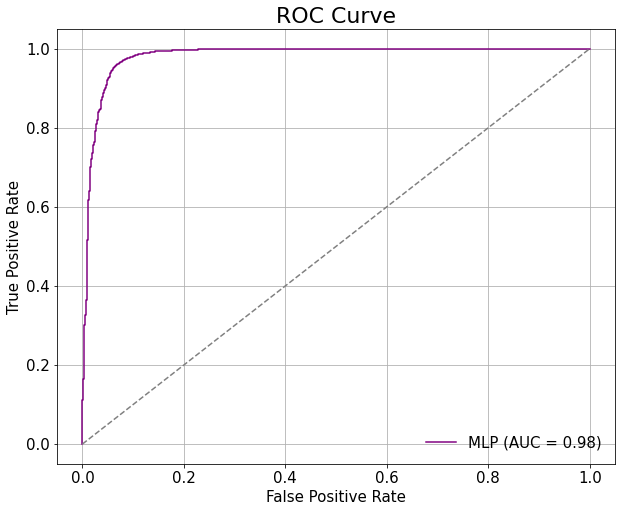

In [39]:
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, label=f"MLP (AUC = {roc_auc:.2f})", color="Purple")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")  # Random guess line
plt.xlabel("False Positive Rate", fontsize=15)
plt.ylabel("True Positive Rate", fontsize=15)
plt.title("ROC Curve", fontsize=22)
plt.legend(frameon=False, fontsize=15)
plt.grid()
plt.tick_params(axis="both", labelsize=15)
plt.show()

#### Final score

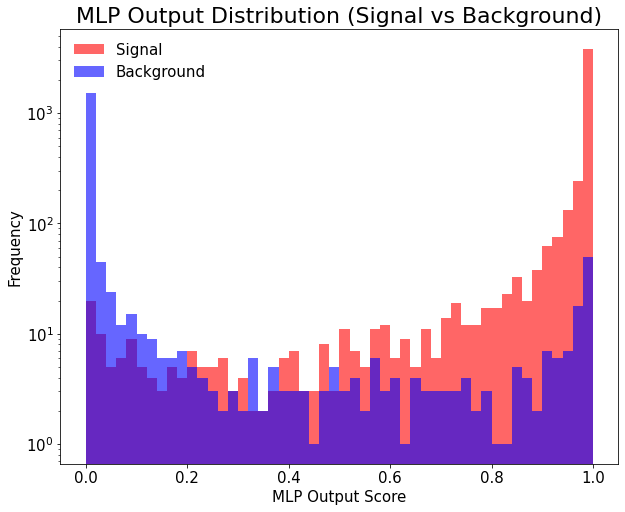

In [40]:
plt.figure(figsize=(10, 8))
plt.hist(y_prob[y_test == 1], bins=50, alpha=0.6, color='r', label='Signal')
plt.hist(y_prob[y_test == 0], bins=50, alpha=0.6, color='b', label='Background')
plt.xlabel("MLP Output Score", fontsize=15)
plt.ylabel("Frequency", fontsize=15)
plt.title("MLP Output Distribution (Signal vs Background)", fontsize=22)
plt.legend(frameon=False, fontsize=15)
plt.tick_params(axis="both", labelsize=15)
plt.yscale('log')
plt.show()

### 5) Apply your model to an  independent dataset

In [41]:
mlp = joblib.load("mlp_model.pkl")  
scaler = joblib.load("scaler.pkl")  

In [42]:
app_signal_root_file = uproot.open("./new_Ntuple_ZpToVisible_5000_MeV.root")
app_background_root_file = uproot.open("./new_Zp_MuMuMuMu_4C_10.root")

In [43]:
app_signal_tree = app_signal_root_file["zp"]
app_background_tree = app_background_root_file["zp"]

In [44]:
app_signal_data = signal_tree.arrays(branches, library="pd")
app_background_data = background_tree.arrays(branches, library="pd")

In [45]:
app_background_data = app_background_data[(app_background_data['Zp_M_beforeFit'] > 4.5) & (app_background_data['Zp_M_beforeFit'] < 5.5)]                                 
app_signal_data = app_signal_data[(app_signal_data['Zp_tau_0_dau_genMotherPDG'] == 26) & (app_signal_data['Zp_tau_1_dau_genMotherPDG'] == 26)]

In [46]:
signal_features = app_signal_tree.arrays(selected, library="np")
background_features = app_background_tree.arrays(selected, library="np")

In [47]:
signal_mass = app_signal_tree["Zp_M_beforeFit"].array(library="np") 
background_mass = app_background_tree["Zp_M_beforeFit"].array(library="np")

In [48]:
X_signal_app = np.column_stack([signal_features[f] for f in selected])
X_background_app = np.column_stack([background_features[f] for f in selected])

In [49]:
y_signal_app = np.ones(len(X_signal_app))
y_background_app = np.zeros(len(X_background_app))

In [50]:
X_app = np.vstack((X_signal_app, X_background_app))
y_app = np.hstack((y_signal_app, y_background_app))
mass = np.hstack((signal_mass, background_mass))

In [51]:
print(len(mass), len(X_app), len(y_app))

154229 154229 154229


In [52]:
X_test = scaler.transform(X_test)

In [53]:
y_scores = mlp.predict_proba(X_test)[:, 1]

In [54]:
from matplotlib.widgets import Slider

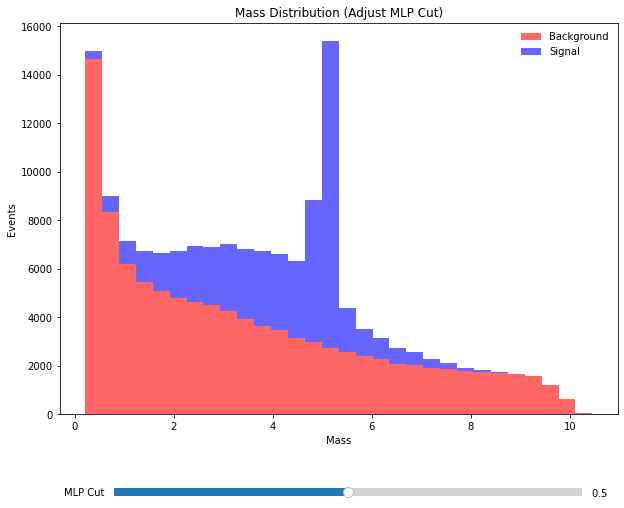

In [55]:
fig, ax = plt.subplots(figsize=(10, 8))
plt.subplots_adjust(bottom=0.2)

def update(val):
    cut_value = slider.val
    selected_signal_mass = mass_test[(y_scores > cut_value) & (y_app == 1)] 
    selected_background_mass = mass_test[(y_scores > cut_value) & (y_app == 0)]  
    ax.clear()
    ax.hist([selected_background_mass, selected_signal_mass], bins=30, stacked=True, 
            color=['red', 'blue'], label=['Background', 'Signal'], edgecolor='None', alpha=0.6)
    ax.set_title(f"Mass Distribution (MLP Cut: {cut_value:.2f})")
    ax.set_xlabel("Mass")
    ax.set_ylabel("Events")
    ax.legend()
    plt.draw()


# Initial plot (No cut applied)
ax.hist([mass[y_app == 0], mass[y_app == 1]], bins=30, stacked=True, 
        color=['red', 'blue'], label=['Background', 'Signal'], edgecolor='none', alpha=0.6)
ax.set_title("Mass Distribution (Adjust MLP Cut)")
ax.set_xlabel("Mass")
ax.set_ylabel("Events")
ax.legend(frameon=False)

# Slider for adjusting MLP score threshold
ax_slider = plt.axes([0.2, 0.05, 0.65, 0.03])
slider = Slider(ax_slider, 'MLP Cut', 0, 1, valinit=0.5, valstep=0.1)
slider.on_changed(update)

plt.show()
